In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
from time import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
vgg16 = torch.load("vgg16_trained.pth")

In [2]:
def dataset_reader(path):
    """Function to iterate over each file in the dataset and read it using opencv
    We are reading file name as label which will be processed further.
    """
    images=[]
    labels=[]
    for DIR,SUB,files in os.walk(path):
        for file in files:
            print(path+file)
            try:
                image=cv2.imread(path+file)
                #image=cv2.resize(image,(180,240))
                image=cv2.resize(image,(60,80))
                images.append(image)
                labels.append(str(file)[:-4])
            except:
                print("skipped")
                pass
    return [images,labels]

In [3]:
data,labels=dataset_reader("weather_dataset/")

weather_dataset/cloudy1.jpg
weather_dataset/cloudy10.jpg
weather_dataset/cloudy100.jpg
weather_dataset/cloudy101.jpg
weather_dataset/cloudy102.jpg
weather_dataset/cloudy103.jpg
weather_dataset/cloudy104.jpg
weather_dataset/cloudy105.jpg
weather_dataset/cloudy106.jpg
weather_dataset/cloudy107.jpg
weather_dataset/cloudy108.jpg
weather_dataset/cloudy109.jpg
weather_dataset/cloudy11.jpg
weather_dataset/cloudy110.jpg
weather_dataset/cloudy111.jpg
weather_dataset/cloudy112.jpg
weather_dataset/cloudy113.jpg
weather_dataset/cloudy114.jpg
weather_dataset/cloudy115.jpg
weather_dataset/cloudy116.jpg
weather_dataset/cloudy117.jpg
weather_dataset/cloudy118.jpg
weather_dataset/cloudy119.jpg
weather_dataset/cloudy12.jpg
weather_dataset/cloudy120.jpg
weather_dataset/cloudy121.jpg
weather_dataset/cloudy122.jpg
weather_dataset/cloudy123.jpg
weather_dataset/cloudy124.jpg
weather_dataset/cloudy125.jpg
weather_dataset/cloudy126.jpg
weather_dataset/cloudy127.jpg
weather_dataset/cloudy128.jpg
weather_dataset

In [3]:


def show_image(image):


# Load the image
    #image = mpimg.imread(image)  # Replace with your image file path

# Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()

In [4]:
def extract_alpha(label_name):
    """ Function to remove numbers from the file name and 
    
    return all the characters including characters
    """
    extracted_label=" "
    for char in label_name:
        if char.isalpha():
            extracted_label+=char
        else:
            pass
            
    return extracted_label.strip()



In [6]:
labels=list(map(extract_alpha,labels))
labels[0]

'cloudy'

In [7]:



#labels = ['cloudy', 'rain', 'shine', 'sunrise']

# Manually encode the labels
label_to_index = {label: idx for idx, label in enumerate(set(labels))}
encoded_labels = [label_to_index[label] for label in labels]


# le=LabelEncoder()
# Y=le.fit_transform(labels)

# Example labels (encoded as integers)
encoded_labels = torch.tensor(encoded_labels)

# One-hot encode the labels
#one_hot_labels = F.one_hot(encoded_labels, num_classes=4)

# print(one_hot_labels)
encoded_labels[0]


tensor(0)

In [8]:
type(encoded_labels[0])

torch.Tensor

In [5]:
def prepare_data(image):
    """ Normalize the image pixel from range of 0-255 to the range of 0-1 so that network can learn fast
    """
    return image/255.0


In [ ]:
X=list(map(prepare_data,data))

In [10]:
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)


In [11]:
y_tensor = encoded_labels.clone()

In [12]:
train_ratio = 0.8
train_size = int(X_tensor.size(0) * train_ratio)

# 打乱数据集
indices = torch.randperm(X_tensor.size(0))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# 划分数据集
X_train, X_test = X_tensor[train_indices], X_tensor[test_indices]
y_train, y_test = y_tensor[train_indices], y_tensor[test_indices]

In [13]:
# prompt: build VGG16

import torchvision.models as models

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers except the classifier
for param in vgg16.features.parameters():
  param.requires_grad = False

# Modify the classifier to fit your number of classes
num_classes = 4  # Replace with your actual number of classes
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Print the modified model summary
print(vgg16)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# prompt: write code to train the above vgg16

# Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

# prompt: write code to train the above vgg16, including the validation accuracy

# ... (Preceding code)

# Train the model with validation
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Create DataLoader for validation
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(labels)
        

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # Validation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            # labels = labels.reshape(labels.shape[0],1)
            # _, true_labels = torch.max(labels.data, 1) 
            
            # correct += (predicted == true_labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}")


Epoch 1, Loss: 1.105681018034617
Validation Accuracy: 81.33333333333333
Epoch 2, Loss: 0.6176741180320581
Validation Accuracy: 79.11111111111111
Epoch 3, Loss: 0.5243544399738309
Validation Accuracy: 84.0
Epoch 4, Loss: 0.3548091401035587
Validation Accuracy: 86.66666666666667
Epoch 5, Loss: 0.3139206632971764
Validation Accuracy: 92.0
Epoch 6, Loss: 0.22764236362030107
Validation Accuracy: 88.44444444444444
Epoch 7, Loss: 0.21604006985823312
Validation Accuracy: 88.88888888888889
Epoch 8, Loss: 0.37329501314088703
Validation Accuracy: 87.55555555555556
Epoch 9, Loss: 0.2451321721387406
Validation Accuracy: 86.22222222222223
Epoch 10, Loss: 0.2946199913819631
Validation Accuracy: 88.88888888888889
Epoch 11, Loss: 0.3809717820335512
Validation Accuracy: 86.66666666666667
Epoch 12, Loss: 0.3718608498573303
Validation Accuracy: 89.77777777777777
Epoch 13, Loss: 0.3922184721321779
Validation Accuracy: 86.22222222222223
Epoch 14, Loss: 0.22328942405292765
Validation Accuracy: 86.22222222222

In [15]:
torch.save(vgg16,"vgg16_trained_60.pth")

In [6]:
vgg16 = torch.load("vgg16_trained_60.pth")

In [7]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        #self.initialize_parameters()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return F.softmax(x, dim=1)
    
    def initialize_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.01)  # Initialize weights with normal distribution
                
                # if module.bias is not None:
                #     nn.init.zeros_(module.bias)

class SquaredHellingerLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, CLIPEx_pred, neural_pred):
        #print(neural_pred.shape)
        neural_pred = F.one_hot(neural_pred, num_classes=4)
        # Calculate the Hellinger distance
        #CLIPEx_pred = torch.clamp(CLIPEx_pred, min=0)
        sqrt_p = torch.sqrt(CLIPEx_pred)
        sqrt_q = torch.sqrt(neural_pred)

        hellinger_dist = torch.sum((sqrt_p - sqrt_q) ** 2, dim=1)

        # Return the mean squared Hellinger distance
        return torch.mean(hellinger_dist)/2

class SquaredLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, CLIPEx_pred, neural_pred):

        neural_pred = F.one_hot(neural_pred, num_classes=4)
        # Calculate the Hellinger distance

        sqrt_p = torch.sqrt(CLIPEx_pred)
        sqrt_q = torch.sqrt(neural_pred)

        hellinger_dist = torch.sum((CLIPEx_pred - neural_pred) ** 2, dim=1)

        # Return the mean squared Hellinger distance
        return torch.mean(hellinger_dist)/2


class TVDistanceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, CLIPEx_pred, neural_pred):

        neural_pred = F.one_hot(neural_pred, num_classes=4)
        # Calculate the Hellinger distance

        #sqrt_p = torch.sqrt(CLIPEx_pred)
        #sqrt_q = torch.sqrt(neural_pred)

        hellinger_dist = torch.sum(torch.abs(CLIPEx_pred - neural_pred) , dim=1)

        # Return the mean squared Hellinger distance
        return torch.mean(hellinger_dist)/2


In [8]:
@torch.no_grad()
def get_loss(loader, criterion, model):
    loss_mini_batch_list = []
    for index, (data, labels) in enumerate(loader):
      # Giving data to cuda
        data = data.reshape(data.size(0), -1).to(device=device)
        #Recall that each MNIST image is originally a 28 x 28 matrix which was in the last 2 dimensions of data
        #The "-1" vectorizes the last 2 dimensions of data
        #So now,  data is now a mini-batch-size x (28^2) matrix - as what the "model" i.e the net requires to get as input
        labels = labels.to(device=device)
        # forward pass
        y_hat = model(data)
        #print("y_hat:"+str(y_hat))
        #print("label:"+str(labels))
        loss = criterion(y_hat, labels)
        loss_mini_batch_list.append(loss)
    return loss_mini_batch_list


def get_accuracy(loader, model):
    correct_pred = 0
    num_samples = 0
    #model.eval()
    for data, labels in loader:
        data = data.reshape(-1, 3 * 180 * 240).to(device=device)
        labels = labels.to(device=device)

        scores = model(data)
        _, preds = scores.max(1)
        #print(preds.shape)
        #print(labels.shape)
        correct_pred += (preds == labels).sum().item()
        num_samples += labels.size(0)


    return (float(correct_pred)/float(num_samples))*100

    #print(f'There were {correct_pred} correct predictions out of {num_samples} samples with and accuracy of {float(correct_pred)/float(num_samples)*100:.2f}')
    #model.train()


In [9]:

def Complex_Neural_Training (epochs, lr, model, train_loader, criterion_train,criterion_test, optimizer, test_loader,L2_lambda):
    train_loss_dynamics = []
    test_loss_dynamics = []

    TV_loss_dynamics = []
    #validation_loss_dynamics = []
    accuracy = []

    for epoch in range(epochs):
        training_loss_list = []
        for index, (data, labels) in enumerate(train_loader):
            # Giving data to cuda
            #print(data.shape)
            data = data.reshape(data.size(0), -1).to(device=device)
            #print(data)
            labels = labels.to(device=device)
            # forward pass
            y_hat = model(data)
            #print(y_hat)
            loss = criterion_train(y_hat, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())/(2*len(labels))
            loss = loss + L2_lambda * l2_norm
            loss.requires_grad_(True)

            #Computing The Gradient On The Mini-Batch Loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
            #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.05)
            #Computing The ADAM Update Using The Above Computed Stochastic Gradient
            optimizer.step()
            optimizer.zero_grad()


        #validation_loss = torch.stack(get_loss(validation_loader, criterion, model)).mean().item()
        training_loss = torch.stack(get_loss(train_loader, criterion_train, model)).mean().item()

        test_loss = torch.stack(get_loss(test_loader, criterion_train, model)).mean().item()
        TV_test_loss = torch.stack(get_loss(test_loader, criterion_test, model)).mean().item()
        #The above computes the empirical and test loss on the whole training and the test data respectively.


        #The above computes the empirical and test classification risk on the whole training and the test data respectively.

        train_loss_dynamics.append(training_loss)
        test_loss_dynamics.append(test_loss)
        TV_loss_dynamics.append(TV_test_loss)
        #validation_loss_dynamics.append(validation_loss)

        print (f'Epoch [{epoch+1}/{epochs}]: The training loss is {training_loss:.4f}')

    return train_loss_dynamics, test_loss_dynamics, TV_loss_dynamics


def Neural_only_Training (epochs, lr, model, train_loader, criterion, optimizer):
    train_loss_dynamics = []
    #test_loss_dynamics = []
    train_accuracy_dynamics = []
    #test_accuracy_dynamics = []
    #validation_loss_dynamics = []
    accuracy = []

    for epoch in range(epochs):
        training_loss_list = []
        for index, (data, labels) in enumerate(train_loader):
            # Giving data to cuda
            data = data.reshape(data.size(0), -1).to(device=device)
            labels = labels.to(device=device)
            # forward pass
            y_hat = model(data)
            loss = criterion(y_hat, labels)
            loss.requires_grad_(True)

            #Computing The Gradient On The Mini-Batch Loss
            loss.backward()

            #Computing The ADAM Update Using The Above Computed Stochastic Gradient
            optimizer.step()
            optimizer.zero_grad()


        #validation_loss = torch.stack(get_loss(validation_loader, criterion, model)).mean().item()
        training_loss = torch.stack(get_loss(train_loader, criterion, model)).mean().item()
        #test_loss = torch.stack(get_loss(test_loader, criterion, model)).mean().item()
        #The above computes the empirical and test loss on the whole training and the test data respectively.

        train_accuracy_dynamics.append(get_accuracy(train_loader,model))
        #test_accuracy_dynamics.append(get_accuracy(test_loader,model))
        #The above computes the empirical and test classification risk on the whole training and the test data respectively.

        train_loss_dynamics.append(training_loss)
        #test_loss_dynamics.append(test_loss)
        #validation_loss_dynamics.append(validation_loss)

        print (f'Epoch [{epoch+1}/{epochs}]: The training loss is {training_loss:.4f}')

    return train_accuracy_dynamics, train_loss_dynamics

In [10]:
data_for_explain,labels_ep=dataset_reader("weather_dataset/")


weather_dataset/cloudy1.jpg
weather_dataset/cloudy10.jpg
weather_dataset/cloudy100.jpg
weather_dataset/cloudy101.jpg
weather_dataset/cloudy102.jpg
weather_dataset/cloudy103.jpg
weather_dataset/cloudy104.jpg
weather_dataset/cloudy105.jpg
weather_dataset/cloudy106.jpg
weather_dataset/cloudy107.jpg
weather_dataset/cloudy108.jpg
weather_dataset/cloudy109.jpg
weather_dataset/cloudy11.jpg
weather_dataset/cloudy110.jpg
weather_dataset/cloudy111.jpg
weather_dataset/cloudy112.jpg
weather_dataset/cloudy113.jpg
weather_dataset/cloudy114.jpg
weather_dataset/cloudy115.jpg
weather_dataset/cloudy116.jpg
weather_dataset/cloudy117.jpg
weather_dataset/cloudy118.jpg
weather_dataset/cloudy119.jpg
weather_dataset/cloudy12.jpg
weather_dataset/cloudy120.jpg
weather_dataset/cloudy121.jpg
weather_dataset/cloudy122.jpg
weather_dataset/cloudy123.jpg
weather_dataset/cloudy124.jpg
weather_dataset/cloudy125.jpg
weather_dataset/cloudy126.jpg
weather_dataset/cloudy127.jpg
weather_dataset/cloudy128.jpg
weather_dataset

In [11]:

labels_ep=list(map(extract_alpha,labels_ep))

In [12]:
labels_ep[0]

'cloudy'

In [13]:
label_to_index_ep = {label: idx for idx, label in enumerate(set(labels_ep))}
encoded_labels_ep = [label_to_index_ep[label] for label in labels_ep]

In [14]:
encoded_labels_ep[2]

0

In [15]:
label_class = {i: None for i in range(0,4)}
index = 0
for img, label in zip(data_for_explain,encoded_labels_ep):
    #print(label)
    if label_class [label] is None:
        label_class [label] = labels_ep[index]
    if all(v is not None for v in label_class.values()):
        break
    index+=1
print(label_class)

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}


In [16]:
label_class = {0:'cloudy',1:'rain',2:'shine',3:'sunrise'}

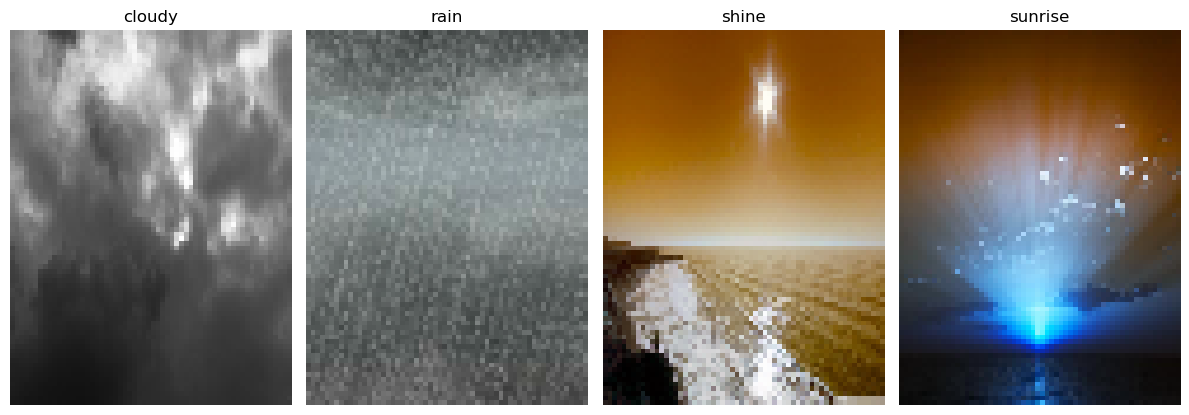

In [16]:
def imshow(img, title):
    #img = img.numpy().squeeze()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

image_set2 = []
label_set2=[]
samples2 = {i: None for i in range(0,4)}  # 1 to 26 for EMNIST letters
for img, label in zip(data_for_explain,encoded_labels_ep):
    if samples2[label] is None:
        samples2[label] = img
    if all(v is not None for v in samples2.values()):
        break

#index_to_letter2 = {i: chr(i + ord('A') - 1) for i in range(1, 27)}
number_to_weather=label_class
plt.figure(figsize=(12, 6))
for idx, (label, img) in enumerate(samples2.items(), start=1):
    image_set2.append(img)
    label_set2.append(label)
    plt.subplot(1,4, idx)
    imshow(img, number_to_weather[label])

plt.tight_layout()
plt.show()

In [27]:
tempt = image_set2[0]
image_set2[0]=image_set2[1]
image_set2[1]=image_set2[2]
image_set2[2]=tempt

In [17]:
transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)
image_normalized = []
for image in image_set2:
    normalized_image = transform1(image)
    image_normalized.append(normalized_image)

In [24]:
print("noralized shape:",image_normalized[0].shape)
print("original shape:",image_set2[0].shape)

noralized shape: torch.Size([3, 80, 60])
original shape: (80, 60, 3)


In [20]:
print("noralized shape:",image_normalized[0].transpose(0,2).shape)
print("original shape:",image_set2[0].shape)

noralized shape: torch.Size([180, 240, 3])
original shape: (240, 180, 3)


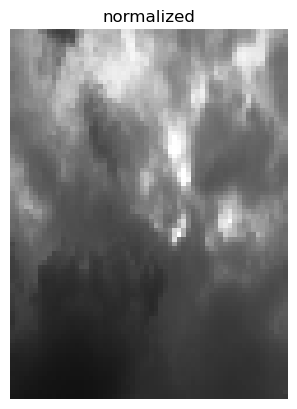

In [33]:
imshow(image_normalized[0].transpose(0,2).transpose(0,1),"normalized")

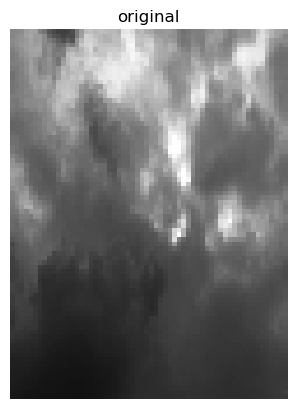

In [34]:
imshow(image_set2[0],"original")

In [18]:
def create_pertubation(input, n_sample, mean, sigma,model):
    pertubation_set = []
    label = []
    for i in range(n_sample):
        noise = np.random.normal(mean,sigma,input.shape) # 
        gaussian_out = input + noise
        
        
        gaussian_out = np.clip(gaussian_out, 0,1)
        
        gaussian_out = np.uint8(gaussian_out)#normal
        
        #print(gaussian_out.shape)
        gaussian_out = torch.from_numpy(gaussian_out).to(torch.float32)
        

        gaussian_out = gaussian_out.unsqueeze(0).to(device="cuda")
        #print(gaussian_out.shape)

        predict = model(gaussian_out)
        #print(predict)
        gaussian_out = gaussian_out.cpu().detach().numpy()
        pertubation_set.append(gaussian_out)
        
        predict = torch.argmax(predict, -1)
        #print(predict)
        label.append(predict)
        #print(gaussian_out)
        
    
    return_set = pertubation_set
    pertubation_set = torch.tensor(pertubation_set).cuda()
    #label = pertubation_set = torch.tensor(label).cuda()
    label =torch.tensor([item.cpu().detach().numpy() for item in label]).cuda()
    label=label.squeeze()
    
    #print(label[0].shape)
    Train_DS = TensorDataset(pertubation_set,label)
    Train_DL = DataLoader(Train_DS,shuffle=True,batch_size = 128)
    return Train_DL #, return_set

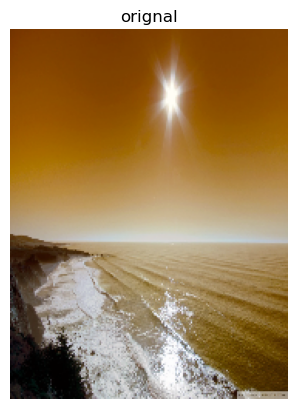

In [172]:
imshow(image_set2[0],'orignal')

In [209]:
tes1= create_pertubation(image_normalized[0],500,0,5,vgg16)

tensor([[[0.1922, 0.2157, 0.2275,  ..., 0.2275, 0.2275, 0.2235],
         [0.2039, 0.2314, 0.2353,  ..., 0.2275, 0.2275, 0.2314],
         [0.2196, 0.2392, 0.2392,  ..., 0.2275, 0.2314, 0.2314],
         ...,
         [0.0431, 0.0392, 0.0431,  ..., 0.0706, 0.0627, 0.0627],
         [0.0471, 0.0471, 0.0471,  ..., 0.0588, 0.0627, 0.0667],
         [0.0431, 0.0392, 0.0510,  ..., 0.0588, 0.0706, 0.0510]],

        [[0.0745, 0.0941, 0.0941,  ..., 0.0980, 0.0941, 0.0902],
         [0.0863, 0.1020, 0.1098,  ..., 0.0980, 0.0941, 0.0980],
         [0.0941, 0.1059, 0.1176,  ..., 0.0980, 0.1059, 0.1059],
         ...,
         [0.0471, 0.0431, 0.0431,  ..., 0.0627, 0.0549, 0.0549],
         [0.0510, 0.0510, 0.0471,  ..., 0.0510, 0.0549, 0.0588],
         [0.0431, 0.0392, 0.0510,  ..., 0.0588, 0.0706, 0.0510]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [53]:
#t2 = time()
input_size = 3 * 90 * 120

simple_model = LinearClassifier(input_size, 4).to(device)
training_epoch = 1000
# train_accuracy_dynamics, train_loss_dynamics = Neural_Training(training_epoch, eta, simple_model, 
#             Train_DL, criterion_train2, torch.optim.Adam(simple_model.parameters(), lr=0.001,weight_decay=0.0001))
simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training(training_epoch, 0.001, simple_model, 
            Train_DL, criterion_train2,criterion_test, torch.optim.Adam(simple_model.parameters(), lr=0.001),test_DL,0.0001)
#t3 = time()
#print('Generating time:'+str(t2-t1),'Training time:',str(t3-t2))

Epoch [1/1000]: The training loss is 0.0193
Epoch [2/1000]: The training loss is 0.0062
Epoch [3/1000]: The training loss is 0.0054
Epoch [4/1000]: The training loss is 0.0050
Epoch [5/1000]: The training loss is 0.0052
Epoch [6/1000]: The training loss is 0.0054
Epoch [7/1000]: The training loss is 0.0052
Epoch [8/1000]: The training loss is 0.0050
Epoch [9/1000]: The training loss is 0.0050
Epoch [10/1000]: The training loss is 0.0052
Epoch [11/1000]: The training loss is 0.0052
Epoch [12/1000]: The training loss is 0.0050
Epoch [13/1000]: The training loss is 0.0052
Epoch [14/1000]: The training loss is 0.0050
Epoch [15/1000]: The training loss is 0.0052
Epoch [16/1000]: The training loss is 0.0050
Epoch [17/1000]: The training loss is 0.0050
Epoch [18/1000]: The training loss is 0.0049
Epoch [19/1000]: The training loss is 0.0049
Epoch [20/1000]: The training loss is 0.0049
Epoch [21/1000]: The training loss is 0.0049
Epoch [22/1000]: The training loss is 0.0049
Epoch [23/1000]: Th

In [32]:
print(simple_test_loss)

[0.5021530985832214, 0.501809298992157, 0.5014607906341553, 0.5011175870895386, 0.5007755160331726, 0.5004245042800903, 0.5000783205032349, 0.4997286796569824, 0.4993869960308075, 0.49904391169548035, 0.49870023131370544, 0.4983508586883545, 0.4980039596557617, 0.49766474962234497, 0.49731478095054626, 0.4969601631164551, 0.4966150224208832, 0.49627169966697693, 0.49592921137809753, 0.49558496475219727, 0.4952312111854553, 0.49489259719848633, 0.49453863501548767, 0.4941938519477844, 0.49384599924087524, 0.4934943616390228, 0.4931497275829315, 0.4928002953529358, 0.4924512803554535, 0.492107629776001, 0.49176350235939026, 0.49141713976860046, 0.49107369780540466, 0.49072757363319397, 0.49037572741508484, 0.4900214374065399, 0.48967239260673523, 0.4893326759338379, 0.4889852702617645, 0.48863300681114197, 0.48828449845314026, 0.48793554306030273, 0.48758649826049805, 0.48723384737968445, 0.486882746219635, 0.4865378439426422, 0.486182302236557, 0.485831081867218, 0.4854806959629059, 0.4

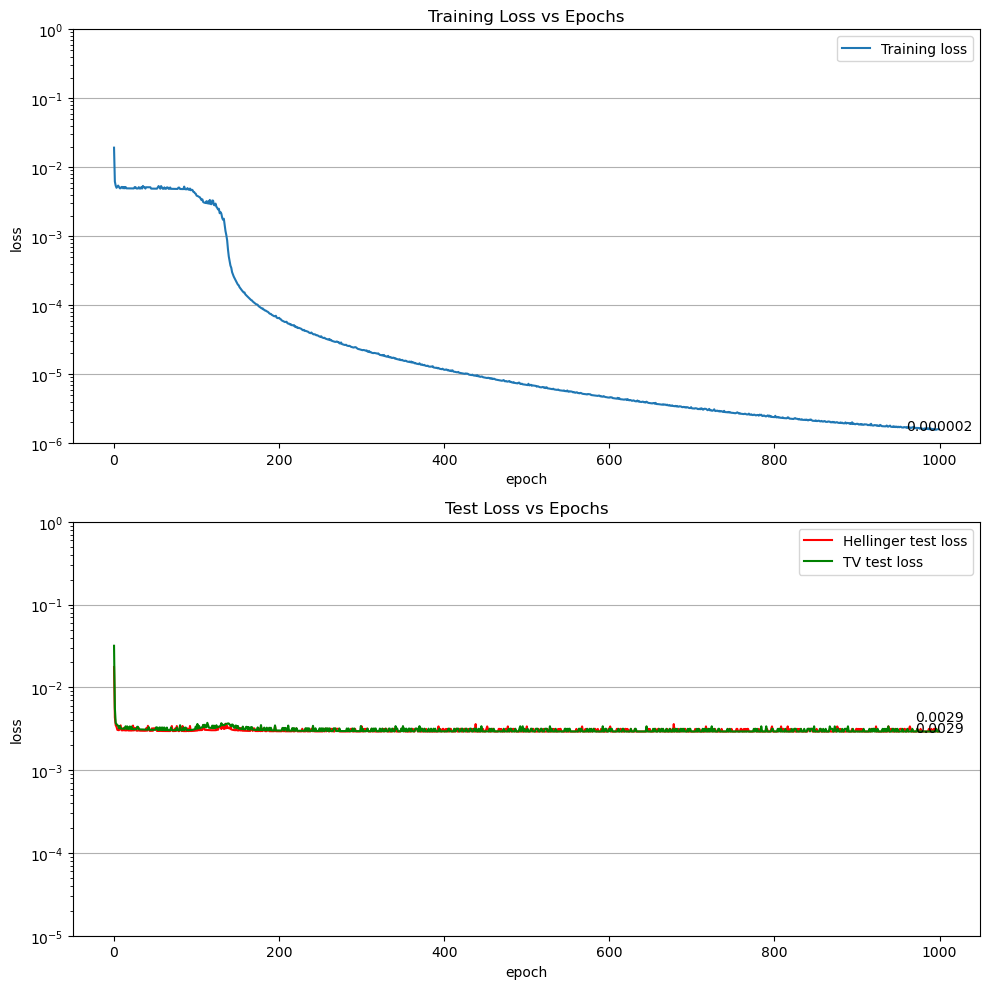

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

#axs[0,0].plot(u_train_loss, '-bx')
axs[0].plot(simple_train_loss)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend(['Training loss'])
axs[0].set_title('Training Loss vs Epochs')
axs[0].yaxis.grid(True)
axs[0].set_ylim(0.000001,1)
axs[0].set_yscale("log",base=10)
axs[0].text(len(simple_train_loss), 1.1*simple_train_loss[-1], f'{simple_train_loss[-1]:.6f}', ha='center', va='center', color='black', fontsize=10)

#axs[0,1].plot(u_test_loss, '-bx')
axs[1].plot(simple_test_loss,color='red')
axs[1].plot(TV_test_loss,color='green')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].legend(['Hellinger test loss','TV test loss'])
axs[1].set_title('Test Loss vs Epochs')
axs[1].yaxis.grid(True)
axs[1].set_ylim(0.00001,1)
axs[1].set_yscale("log",base=10)
axs[1].yaxis.grid(True)
axs[1].text(len(simple_test_loss), 1.1*simple_test_loss[-1], f'{simple_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=10)
axs[1].text(len(TV_test_loss), 1.5*TV_test_loss[-1], f'{TV_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()

In [21]:
def visualize_weights(model, standard_deviation, digit, img_shape=(3, 80, 60)):
    weights = model.linear.weight.data.cpu().numpy()
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    weather = label_class[digit]
    for i in range(4):
        weight = weights[i].reshape(img_shape).transpose(1, 2, 0)
        min_wt, max_wt = weight.min(), weight.max()
        weight = (weight - min_wt) / (max_wt - min_wt)  # normalize for visualization
        axes[i].imshow(weight)
        axes[i].set_title(label_class[i])
        axes[i].axis('off')
    plt.savefig(f'result/C-LIME/5000_0-'+str(standard_deviation)[2:len(str(standard_deviation))]+'/reshape_weight'+weather)
    plt.show()



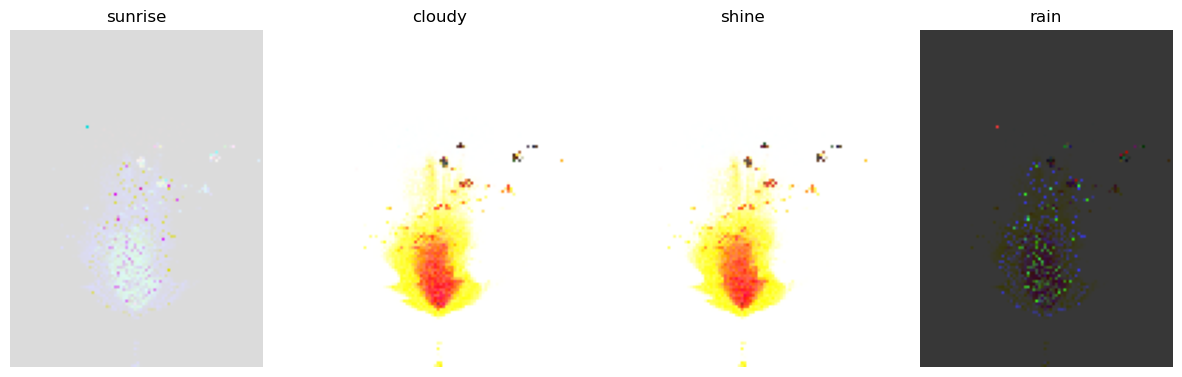

In [56]:
visualize_weights(simple_model,0.1,0)

In [58]:
wt = simple_model.linear.weight.data.cpu().numpy()


In [86]:
wt_0 = wt[0].reshape((3, 120, 90))
count = 0
for i in range(3):
    for x in range(wt[0].reshape((3, 120, 90)).shape[1]):
        for y in range(wt[0].reshape((3, 120, 90)).shape[2]):
            if wt_0[i,x,y] >0:
                count+=1
print(count)

17302


In [71]:
print(wt[0].shape)
print(wt[0].reshape((3, 120, 90)).shape)
print(wt[0].reshape((3, 120, 90)).transpose(1, 2, 0).shape)
print(image_normalized[0].transpose(0,2).transpose(0,1).shape)
print(image_normalized[0].shape)

(32400,)
(3, 120, 90)
(120, 90, 3)
torch.Size([120, 90, 3])
torch.Size([3, 120, 90])


In [87]:
copy_image = image_normalized[0]
wt_0 = wt[0].reshape((3, 120, 90))
for i in range(3):
    for x in range(wt[0].reshape((3, 120, 90)).shape[1]):
        for y in range(wt[0].reshape((3, 120, 90)).shape[2]):
            if wt_0[i,x,y] <0:
                copy_image[i,x,y]=0


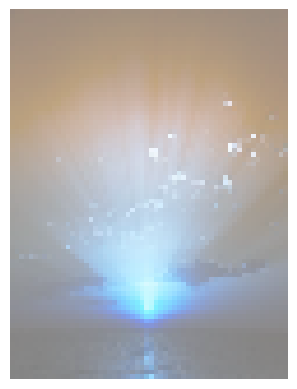

In [54]:
imshow(image_normalized[0])

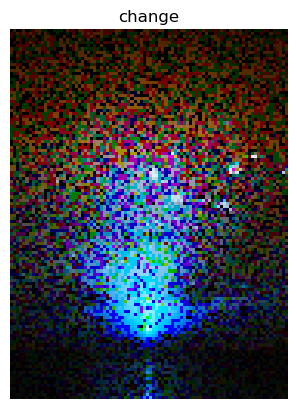

In [88]:
imshow(copy_image.transpose(0,2).transpose(0,1),"change")

In [70]:
image_normalized[0][0,0,0]

tensor(0.1922)

In [38]:

def draw_weight(simple_model,sample_number,standard_deviation,digit):
    Font_Size = 70
    weights = simple_model.state_dict()['linear.weight'].cpu().numpy()
    weather = label_class[digit]
    plt.figure(figsize=(100, 30))
    plt.imshow(weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'Weights of the Linear Classifier (sample number:{sample_number})(standard_deviation:{standard_deviation})(weather:'+weather+')',fontsize=Font_Size)
    plt.xlabel('Pixels (Flattened 3x240x180 Image)',fontsize=Font_Size)
    plt.ylabel('Weather code',fontsize=Font_Size)
    
# Set x-axis labels
    num_pixels = 60 * 80 * 3
    x_ticks = list(range(0, num_pixels, 1600))
    x_labels = [str(i*1600) for i in range(9)]
    plt.xticks(x_ticks, x_labels,fontsize=Font_Size)

# Set y-axis labels
    y_labels = [str(i) for i in range(4)]
    plt.yticks(list(range(4)), y_labels,fontsize=Font_Size)
    plt.savefig(f'result/C-LIME/5000_0-'+str(standard_deviation)[2:len(str(standard_deviation))]+'/weight'+weather)
    plt.show()

def whole_process(sample_number, sd, img1,digit):
    #criterion_train = SquaredHellingerLoss()
    
    criterion_train = SquaredLoss()
    criterion_test = TVDistanceLoss()
    input_size = 3*60*80
    simple_model = LinearClassifier(input_size, 4).to(device)
    dirs = 'result/C-LIME/5000_0-'+str(sd)[2:len(str(sd))]
    
    weather = label_class[digit]
    if not os.path.exists(dirs):
        os.makedirs(dirs)

    train_sample_number = sample_number
    Train_DL = create_pertubation(img1,train_sample_number,0,sd,vgg16)
    print('generate training')
    test_DL = create_pertubation(img1,10*train_sample_number,0,sd,vgg16) #
    print('generate testing')

    if sample_number==5000:
        training_epoch=400
    else:
        training_epoch=250

    simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training(training_epoch, 0.001, simple_model,
            Train_DL, criterion_train,criterion_test, torch.optim.Adam(simple_model.parameters(), lr=0.001),test_DL,0.0001)

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    font_size = 20
#axs[0,0].plot(u_train_loss, '-bx')
    axs[0].plot(simple_train_loss)


    axs[0].set_xlabel('epoch',fontsize=font_size)
    axs[0].set_ylabel('loss',fontsize=font_size)
#axs[0].legend([f'{train_sample_number} train samples'])
    axs[0].legend([f'Train loss for {sample_number} samples' ],fontsize=font_size)
    axs[0].set_title('Training Loss vs Epochs (Standard deviation:'+str(sd)+')',fontsize=font_size)
    axs[0].yaxis.grid(True)
    axs[0].text(len(simple_train_loss), 1.1*simple_train_loss[-1], f'{simple_train_loss[-1]:.6f}', ha='center', va='center', color='black', fontsize=font_size)
    axs[0].text(0, 1.1*simple_train_loss[0], f'{simple_train_loss[0]:.4f}', ha='center', va='center', color='black', fontsize=font_size)
# axs[0].text(150, 0.02, f'{simple_train_loss[150]:.4f}', ha='center', va='center', color='black', fontsize=10)
# axs[0].text(200, 0.01, f'{simple_train_loss[200]:.4f}', ha='center', va='center', color='black', fontsize=10)
# axs[0].text(250, 0.01, f'{simple_train_loss[250]:.4f}', ha='center', va='center', color='black', fontsize=10)
    axs[0].set_ylim(0.000001,1)
    axs[0].set_yscale("log",base=10)

#axs[0].text(800, 0.1, f'{simple_train_loss[800]:.4f}', ha='center', va='center', color='black', fontsize=10)


#axs[0,1].plot(u_test_loss, '-bx')
    axs[1].plot(simple_test_loss, color='red')
    axs[1].plot(TV_test_loss, color='green')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('loss')
    axs[1].legend([f'Hellinger test loss for {10*sample_number} samples',f'TV test loss {10*sample_number} samples'],fontsize=font_size)
    axs[1].set_title('Test Loss vs Epochs',fontsize=font_size)
    axs[1].yaxis.grid(True)
    axs[1].set_ylim(0.000001,1)
    axs[1].set_yscale("log",base=10)
#axs[1].text(50len(simple_test_loss)0, 0.1, f'{simple_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(0, 1.1, f'{simple_test_loss[0]:.4f}', ha='center', va='center', color='black', fontsize=10)
    axs[1].text(len(simple_test_loss), 1.1*simple_test_loss[-1], f'{simple_test_loss[-1]:.6f}', ha='center', va='center', color='black', fontsize=font_size)
    axs[1].text(len(TV_test_loss), 1.5*TV_test_loss[-1], f'{TV_test_loss[-1]:.6f}', ha='center', va='center', color='black', fontsize=font_size)
#axs[1].text(150, 0.02, f'{simple_test_loss[150]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(200, 0.01, f'{simple_test_loss[200]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(250, 0.01, f'{simple_test_loss[250]:.4f}', ha='center', va='center', color='black', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'result/C-LIME/5000_0-'+str(sd)[2:len(str(sd))]+'/loss'+weather)
    draw_weight(simple_model,sample_number,sd,digit)
    visualize_weights(simple_model,sd,digit)






In [ ]:
sn = [5000]
#sd = [0.1,0.05,0.01,0.005,0.001,0.0001]
sd = [1]
for i in sn:
    for j in sd:
        #whole_process(i,j,image_set2[0],1)
        digit=0

        for img in range(0,4):
            whole_process(i,j,image_normalized[img],digit)
            digit =digit+1

In [60]:
normalized_image[0].shape

torch.Size([240, 180])

In [24]:
L2_regularzation = [0.0001,0.001,0.005,0.01,0.05]#
#weight_decay= [0.0001,0.001,0.005,0.01,0.05]#,
img1= image_normalized[1]
train_loss=[]
Htest_loss=[]
TV_loss=[]
input_size = 3*80*60
for l2 in L2_regularzation:
    criterion_train = SquaredHellingerLoss()
    criterion_test = TVDistanceLoss()
    Train_DL = create_pertubation(img1,5000,0,0.0001,vgg16)
    Test_DL = create_pertubation(img1,10*5000,0,0.0001,vgg16)
    model = LinearClassifier(input_size, 4).to(device)
    simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training (400, 0.001, model, Train_DL, criterion_train,criterion_test, torch.optim.Adam(model.parameters(), lr=0.001),Test_DL,l2)
    train_loss.append(simple_train_loss)
    Htest_loss.append(simple_test_loss)
    TV_loss.append(TV_test_loss)

Epoch [1/400]: The training loss is 0.3205
Epoch [2/400]: The training loss is 0.2659
Epoch [3/400]: The training loss is 0.2534
Epoch [4/400]: The training loss is 0.2387
Epoch [5/400]: The training loss is 0.2371
Epoch [6/400]: The training loss is 0.2340
Epoch [7/400]: The training loss is 0.2256
Epoch [8/400]: The training loss is 0.2210
Epoch [9/400]: The training loss is 0.2206
Epoch [10/400]: The training loss is 0.2167
Epoch [11/400]: The training loss is 0.2165
Epoch [12/400]: The training loss is 0.2100
Epoch [13/400]: The training loss is 0.2073
Epoch [14/400]: The training loss is 0.2054
Epoch [15/400]: The training loss is 0.2053
Epoch [16/400]: The training loss is 0.2015
Epoch [17/400]: The training loss is 0.1985
Epoch [18/400]: The training loss is 0.1971
Epoch [19/400]: The training loss is 0.1966
Epoch [20/400]: The training loss is 0.1941
Epoch [21/400]: The training loss is 0.1911
Epoch [22/400]: The training loss is 0.1871
Epoch [23/400]: The training loss is 0.19

In [29]:
def draw_l2(train_loss,Htest_loss,TV_loss,lambda_set):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10),constrained_layout=True)
    for i in train_loss:
        axs[0].plot(i)
    axs[0].set_xlabel('epoch',fontsize=20)
    axs[0].set_ylabel('loss',fontsize=20)
    axs[0].tick_params(axis='both',labelsize=20)
#axs[0].legend([f'{train_sample_number} train samples'])
    axs[0].legend(['λ='+str(i) for i in lambda_set],fontsize=20)
    axs[0].set_title('Training Loss vs Epochs ',fontsize=20)
    #axs[0].text(len(train_loss), 1.1*train_loss[-1], f'{train_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    axs[0].yaxis.grid(True)
    # axs[0].set_ylim(0.0001,1) 
    # axs[0].set_yscale("log",base=10)

#axs[1].plot(train_loss_dynamics, color='red')
    for i in Htest_loss:
        axs[1].plot(i)
    #axs[1].plot(TV_test_loss, color='green')
    axs[1].set_xlabel('epoch',fontsize=20)
    axs[1].set_ylabel('loss',fontsize=20)
    axs[1].tick_params(axis='both',labelsize=20)
    axs[1].legend(['λ='+str(i) for i in lambda_set],fontsize=20)
    axs[1].set_title('Hellinger Test Loss vs Epochs',fontsize=20)
    #axs[1].text(len(Htest_loss), 1.1*Htest_loss[-1], f'{Htest_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    #axs[1].text(len(TV_test_loss), 1.1*TV_test_loss[-1], f'{TV_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
#axs[1].text(400, 1.1*train_loss_dynamics[399], f'{train_loss_dynamics[399]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(351, 1.1*simple_test_loss[350], f'{simple_test_loss[350]:.5f}', ha='center', va='center', color='black', fontsize=20)
    axs[1].yaxis.grid(True)
    # axs[1].set_ylim(0.0001,1) 
    # axs[1].set_yscale("log",base=10)

    #axs[2].plot(Htest_loss, color='red')
    for i in TV_loss:
        axs[2].plot(i)
    axs[2].set_xlabel('epoch',fontsize=20)
    axs[2].set_ylabel('loss',fontsize=20)
    axs[2].tick_params(axis='both',labelsize=20)
    axs[2].legend(['λ='+str(i) for i in lambda_set],fontsize=20)
    axs[2].set_title('TV Test Loss vs Epochs',fontsize=20)
    #axs[2].text(len(Htest_loss), 1.1*Htest_loss[-1], f'{Htest_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    #axs[2].text(len(TV_loss), 1.1*TV_loss[-1], f'{TV_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    axs[2].yaxis.grid(True)
    # axs[2].set_ylim(0.0001,1) 
    # axs[2].set_yscale("log",base=10)

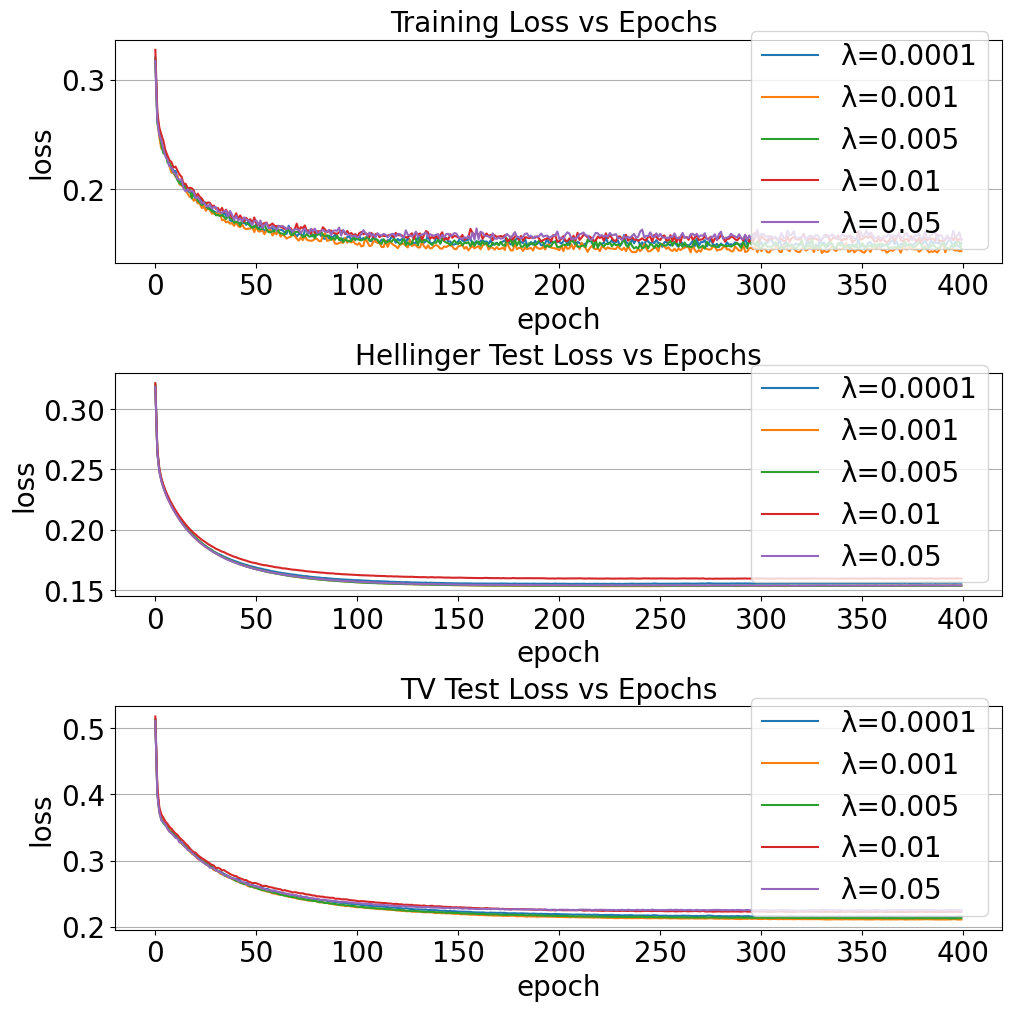

In [30]:
draw_l2(train_loss,Htest_loss,TV_loss,L2_regularzation)

In [31]:
standard_deviation = [0.0001,0.001,0.005,0.01,0.05,0.1]#
#weight_decay= [0.0001,0.001,0.005,0.01,0.05]#,
img1= image_normalized[1]
train_loss=[]
Htest_loss=[]
TV_loss=[]
input_size = 3*80*60
for sd in standard_deviation:
    criterion_train = SquaredHellingerLoss()
    criterion_test = TVDistanceLoss()
    Train_DL = create_pertubation(img1,5000,0,sd,vgg16)
    Test_DL = create_pertubation(img1,10*5000,0,sd,vgg16)
    model = LinearClassifier(input_size, 4).to(device)
    simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training (400, 0.001, model, Train_DL, criterion_train,criterion_test, torch.optim.Adam(model.parameters(), lr=0.001),Test_DL,0.0001)
    train_loss.append(simple_train_loss)
    Htest_loss.append(simple_test_loss)
    TV_loss.append(TV_test_loss)

Epoch [1/400]: The training loss is 0.3197
Epoch [2/400]: The training loss is 0.2665
Epoch [3/400]: The training loss is 0.2503
Epoch [4/400]: The training loss is 0.2416
Epoch [5/400]: The training loss is 0.2358
Epoch [6/400]: The training loss is 0.2330
Epoch [7/400]: The training loss is 0.2260
Epoch [8/400]: The training loss is 0.2234
Epoch [9/400]: The training loss is 0.2202
Epoch [10/400]: The training loss is 0.2178
Epoch [11/400]: The training loss is 0.2151
Epoch [12/400]: The training loss is 0.2104
Epoch [13/400]: The training loss is 0.2074
Epoch [14/400]: The training loss is 0.2051
Epoch [15/400]: The training loss is 0.2021
Epoch [16/400]: The training loss is 0.2016
Epoch [17/400]: The training loss is 0.1990
Epoch [18/400]: The training loss is 0.2000
Epoch [19/400]: The training loss is 0.1948
Epoch [20/400]: The training loss is 0.1933
Epoch [21/400]: The training loss is 0.1918
Epoch [22/400]: The training loss is 0.1932
Epoch [23/400]: The training loss is 0.18

In [34]:
def draw_l2_sigma(train_loss,Htest_loss,TV_loss,sigma_set):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10),constrained_layout=True)
    for i in train_loss:
        axs[0].plot(i)
    axs[0].set_xlabel('epoch',fontsize=20)
    axs[0].set_ylabel('loss',fontsize=20)
    axs[0].tick_params(axis='both',labelsize=20)
#axs[0].legend([f'{train_sample_number} train samples'])
    axs[0].legend(['σ='+str(i) for i in sigma_set],fontsize=15)
    axs[0].set_title('Training Loss vs Epochs ',fontsize=20)
    #axs[0].text(len(train_loss), 1.1*train_loss[-1], f'{train_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    axs[0].yaxis.grid(True)
    # axs[0].set_ylim(0.0001,1) 
    # axs[0].set_yscale("log",base=10)

#axs[1].plot(train_loss_dynamics, color='red')
    for i in Htest_loss:
        axs[1].plot(i)
    #axs[1].plot(TV_test_loss, color='green')
    axs[1].set_xlabel('epoch',fontsize=20)
    axs[1].set_ylabel('loss',fontsize=20)
    axs[1].tick_params(axis='both',labelsize=20)
    axs[1].legend(['σ='+str(i) for i in sigma_set],fontsize=15)
    axs[1].set_title('Hellinger Test Loss vs Epochs',fontsize=20)
    #axs[1].text(len(Htest_loss), 1.1*Htest_loss[-1], f'{Htest_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    #axs[1].text(len(TV_test_loss), 1.1*TV_test_loss[-1], f'{TV_test_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
#axs[1].text(400, 1.1*train_loss_dynamics[399], f'{train_loss_dynamics[399]:.4f}', ha='center', va='center', color='black', fontsize=10)
#axs[1].text(351, 1.1*simple_test_loss[350], f'{simple_test_loss[350]:.5f}', ha='center', va='center', color='black', fontsize=20)
    axs[1].yaxis.grid(True)
    # axs[1].set_ylim(0.0001,1) 
    # axs[1].set_yscale("log",base=10)

    #axs[2].plot(Htest_loss, color='red')
    for i in TV_loss:
        axs[2].plot(i)
    axs[2].set_xlabel('epoch',fontsize=20)
    axs[2].set_ylabel('loss',fontsize=20)
    axs[2].tick_params(axis='both',labelsize=20)
    axs[2].legend(['σ='+str(i) for i in sigma_set],fontsize=15)
    axs[2].set_title('TV Test Loss vs Epochs',fontsize=20)
    #axs[2].text(len(Htest_loss), 1.1*Htest_loss[-1], f'{Htest_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    #axs[2].text(len(TV_loss), 1.1*TV_loss[-1], f'{TV_loss[-1]:.4f}', ha='center', va='center', color='black', fontsize=20)
    axs[2].yaxis.grid(True)
    # axs[2].set_ylim(0.0001,1) 
    # axs[2].set_yscale("log",base=10)

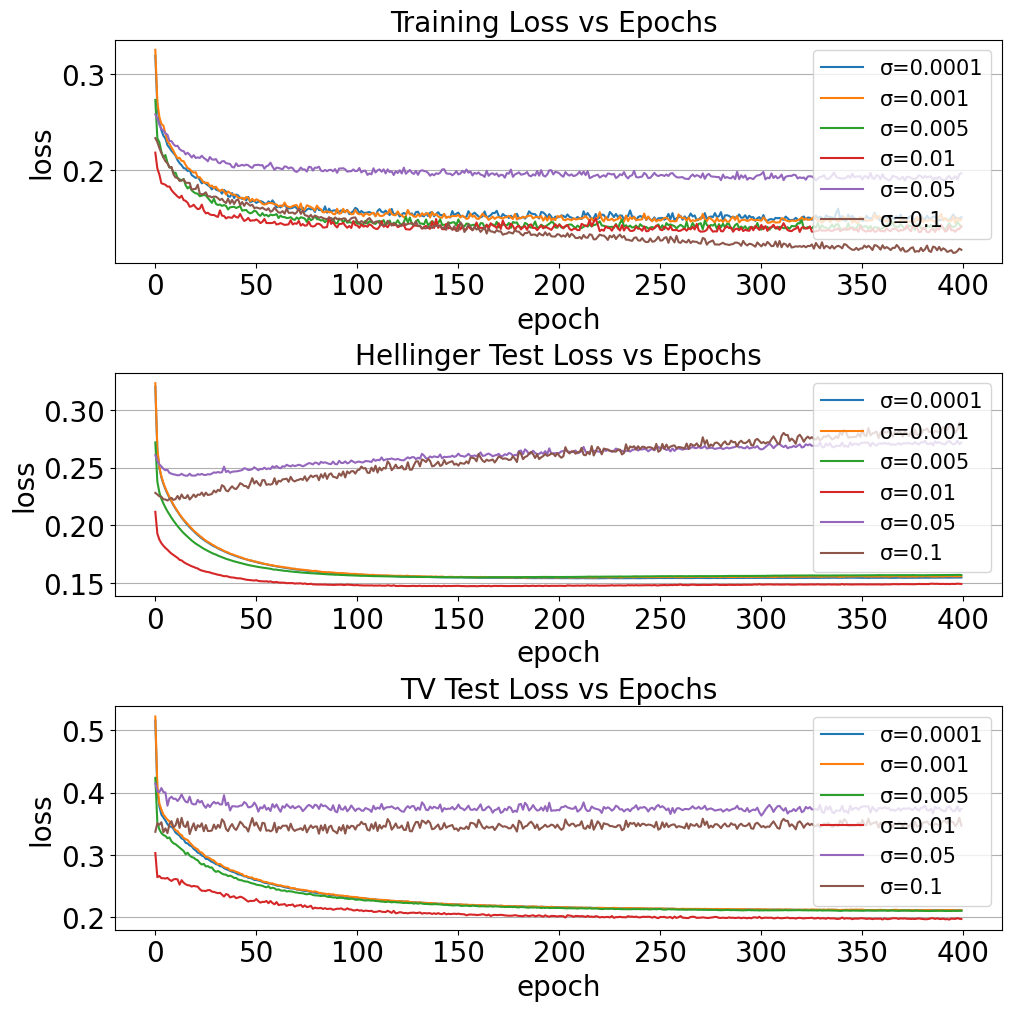

In [35]:
draw_l2_sigma(train_loss,Htest_loss,TV_loss,standard_deviation)

In [67]:
#1000:17.13s
#5000:86.54s
t1=time()
Train_DL = create_pertubation(image_normalized[0],5000,0,0.1,vgg16)
t2=time()
print(str(t2-t1))

86.35909533500671


In [75]:
torch.save(Train_DL,'./dataloader_save.pth')

In [76]:
dataloader_save = torch.load("dataloader_save.pth")

In [23]:
normalized_image[0].shape

torch.Size([80, 60])

In [22]:
label_number = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 3*80*60
img1=image_normalized[label_number]
sd=0.1
criterion_train = SquaredLoss()
criterion_train2 = SquaredHellingerLoss()
criterion_test = TVDistanceLoss()
t1 = time()
train_sample_number = 5000
training_epoch = 400
simple_model = LinearClassifier(input_size, 4).to(device)
Train_DL = create_pertubation(img1,train_sample_number,0,sd,vgg16)
test_DL = create_pertubation(img1,10,0,sd,vgg16) #
t2 = time()
# train_accuracy_dynamics, train_loss_dynamics = Neural_Training(training_epoch, eta, simple_model, 
#             Train_DL, criterion_train2, torch.optim.Adam(simple_model.parameters(), lr=0.001,weight_decay=0.0001))
simple_train_loss, simple_test_loss, TV_test_loss = Complex_Neural_Training(training_epoch, 0.001, simple_model, 
            Train_DL, criterion_train2,criterion_test, torch.optim.Adam(simple_model.parameters(), lr=0.001),test_DL,0.0001)
t3 = time()
print('Generating time:'+str(t2-t1),'Training time:',str(t3-t2))

Epoch [1/400]: The training loss is 0.4865
Epoch [2/400]: The training loss is 0.4742
Epoch [3/400]: The training loss is 0.4619
Epoch [4/400]: The training loss is 0.4493
Epoch [5/400]: The training loss is 0.4375
Epoch [6/400]: The training loss is 0.4248
Epoch [7/400]: The training loss is 0.4130
Epoch [8/400]: The training loss is 0.4020
Epoch [9/400]: The training loss is 0.3886
Epoch [10/400]: The training loss is 0.3809
Epoch [11/400]: The training loss is 0.3681
Epoch [12/400]: The training loss is 0.3572
Epoch [13/400]: The training loss is 0.3482
Epoch [14/400]: The training loss is 0.3413
Epoch [15/400]: The training loss is 0.3275
Epoch [16/400]: The training loss is 0.3219
Epoch [17/400]: The training loss is 0.3138
Epoch [18/400]: The training loss is 0.3054
Epoch [19/400]: The training loss is 0.2970
Epoch [20/400]: The training loss is 0.2886
Epoch [21/400]: The training loss is 0.2835
Epoch [22/400]: The training loss is 0.2762
Epoch [23/400]: The training loss is 0.27

In [35]:
weights = simple_model.linear.weight.data.cpu()

In [45]:
copy_image = image_normalized[0]

In [26]:
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [20]:
def top_weight_image(simple_model, class_number,top,sd):
    dirs = 'result/C-LIPEx/top/0-'+str(sd)[2:len(str(sd))]
    
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    weights = simple_model.linear.weight.data.cpu()  # Tensor of shape [4, 14400] (4 classes, 3*80*60 flattened input)
    weights = weights.view(4, 3, 80, 60)  # Reshape weights to [4, 3, 80, 60]

# Calculate the pixel-wise contributions for a specific class (example: class 0)
    class_index = class_number  # Change this to visualize for different classes
    contributions = image_normalized[class_index] * weights[class_index]  # Element-wise multiplication

# Calculate the absolute contributions and flatten them
    contributions_abs = contributions.abs().sum(dim=0)  # Sum over the channel dimension
    contributions_flat = contributions_abs.view(-1)  # Flatten the contributions

# Find the threshold for the top 10%
    threshold = torch.quantile(contributions_flat, 1-top).item()  # 90th percentile

# Create a mask for the top 10% contributions
    mask = contributions_abs >= threshold  # Boolean mask

# Create an empty image with the same shape and set all pixels to black
    highlighted_image = np.zeros_like(image_normalized[class_index].numpy())
    highlighted_image = np.transpose(highlighted_image, (1, 2, 0))  # Convert to (H, W, C)

# Copy only the top 10% pixels from the original image to the highlighted image
    highlighted_image[mask.numpy()] = np.transpose(image_normalized[class_number], (1, 2, 0))[mask.numpy()]

# Show the original and highlighted images
    #print('Original Image:')
    #imshow(image_normalized[0])
    print('Image with Only Top '+str(top*100)+'% Highlighted Pixels')
    plt.imshow(highlighted_image)
    plt.title(label_class[class_number]+' Top '+str(top*100)+'% pixels with σ='+str(sd))
    plt.axis('off')
   # plt.savefig('result/C-LIPEx/top/0-'+str(sd)[2:len(str(sd))]+'/'+' with '+label_class[class_number]+'_top'+str(top*100)+'.png',bbox_inches='tight')
    plt.show()


Image with Only Top 10.0% Highlighted Pixels


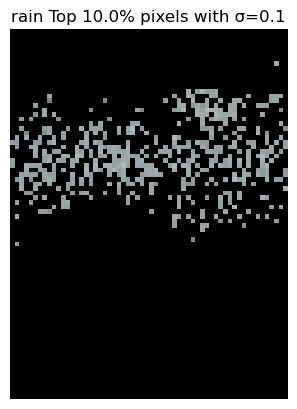

Image with Only Top 20.0% Highlighted Pixels


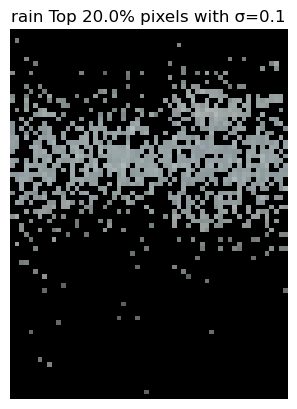

Image with Only Top 30.0% Highlighted Pixels


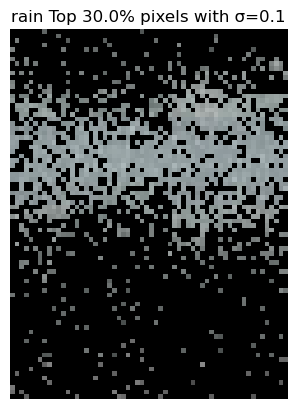

In [23]:
top_set=[0.1,0.2,0.3]
for i in top_set:
    top_weight_image(simple_model,label_number,i,sd)

Image with Only Top 10% Highlighted Pixels:


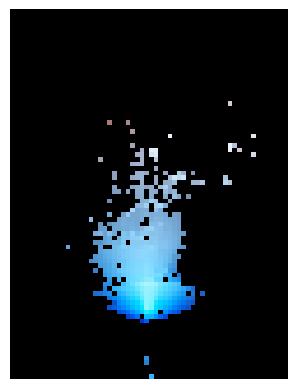

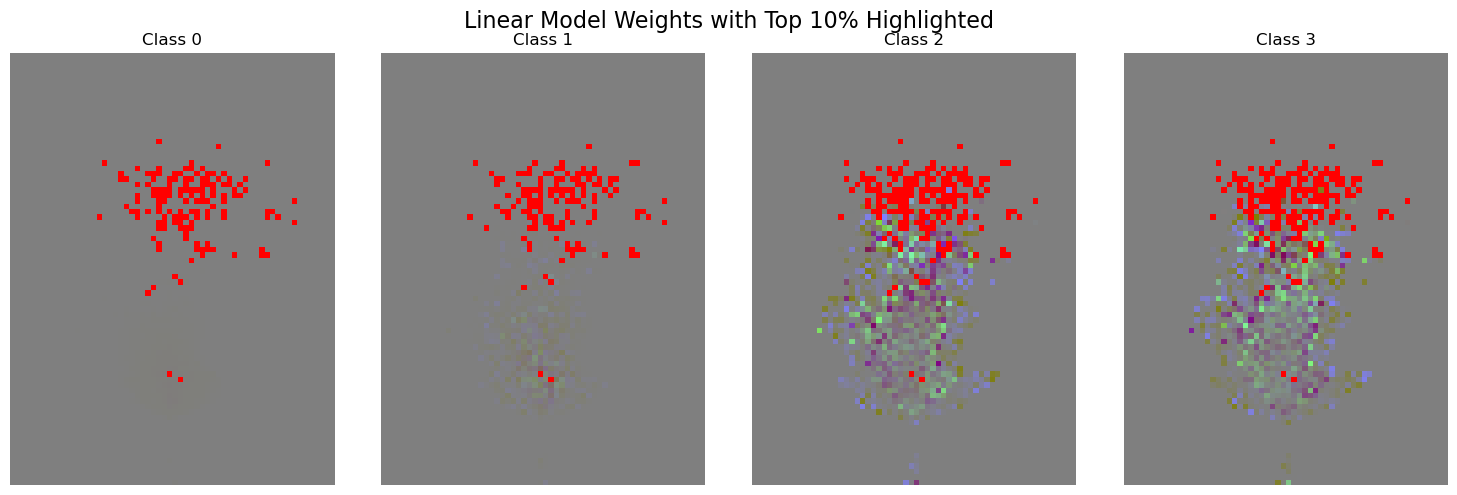

In [ ]:
weights = weights.view(4, 3, 80, 60)  # Shape [4, 3, 80, 60]

# 3. Normalize weights for visualization
min_weight = weights.min()
max_weight = weights.max()
weights_normalized = (weights - min_weight) / (max_weight - min_weight)

# 4. Calculate the threshold for the top 10% of absolute weights
weights_abs = weights.abs()  # Use absolute values to find largest magnitudes
thresholds = torch.quantile(weights_abs.view(4, -1), 0.9, dim=1)  # Find 90th percentile

# 5. Create a mask for the top 10% of weights
masks = weights_abs >= thresholds.view(4, 1, 1, 1)  # Create a boolean mask

# 6. Plot the weights with highlighted pixels
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Create a grid of 1x4 for the 4 classes
fig.suptitle('Linear Model Weights with Top 10% Highlighted', fontsize=16)

for i in range(4):
    ax = axes[i]
    img = weights_normalized[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    # Highlight the top 10% of weights by overlaying the mask
    mask_img = masks[i].permute(1, 2, 0).numpy()  # Convert mask to (H, W, C)
    highlighted_img = img.copy()
    highlighted_img[mask_img[:, :, 0]] = [1.0, 0, 0] # Highlight with red color

    ax.imshow(highlighted_img)
    ax.axis('off')
    ax.set_title(f'Class {i}')

plt.tight_layout()
plt.show()

Image with Only Top 10% Highlighted Pixels:


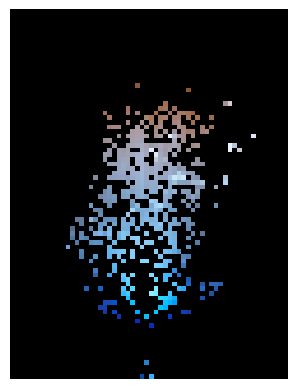

In [72]:
top_weight_image(simple_model,2)

Image with Only Top 10% Highlighted Pixels:


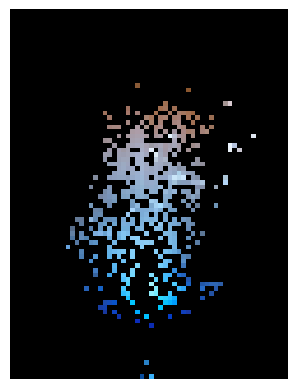

In [73]:
top_weight_image(simple_model,3)

In [44]:
copy_image = image_normalized[0]
wt_0 = wt[0].reshape((3, 120, 90))
for i in range(3):
    for x in range(wt[0].reshape((3, 120, 90)).shape[1]):
        for y in range(wt[0].reshape((3, 120, 90)).shape[2]):
            if wt_0[i,x,y] <0:
                copy_image[i,x,y]=0

torch.Size([3, 80, 60])

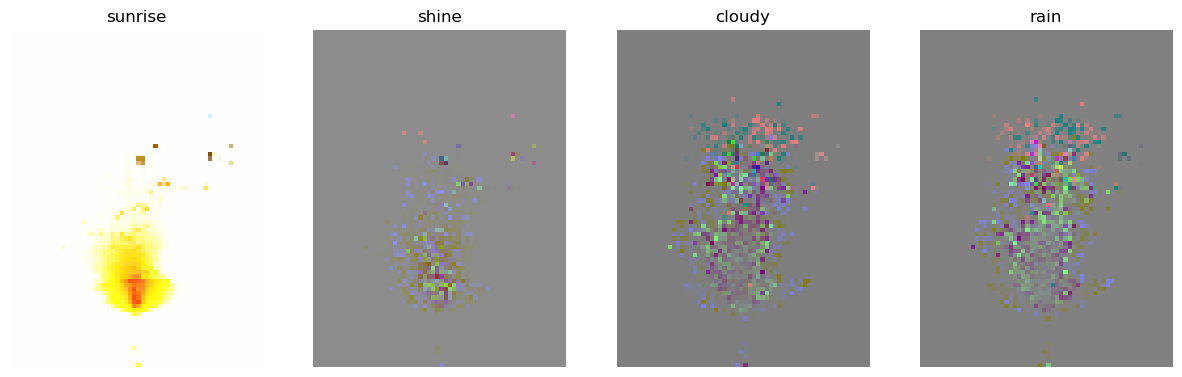

In [59]:
weights = simple_model.linear.weight.data.cpu().numpy()
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
weather = label_class[0]
for i in range(4):
    weight = weights[i].reshape((3, 80, 60)).transpose(1, 2, 0)
    min_wt, max_wt = weight.min(), weight.max()
    weight = (weight - min_wt) / (max_wt - min_wt)  # normalize for visualization
    axes[i].imshow(weight)
    axes[i].set_title(label_class[i])
    axes[i].axis('off')

plt.show()